Library Imports

In [14]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models, transforms
from torchvision.transforms import functional as f
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

from PIL import Image
import time
import copy
import warnings
warnings.filterwarnings("ignore")

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [16]:
data_dir = 'datasets'
train_dir = os.path.join(data_dir, 'Training')
val_dir = os.path.join(data_dir, 'Validation')
test_dir = os.path.join(data_dir, 'Testing')

In [17]:
CATEGORIES = ['glioma', 'meningioma', 'notumor', 'pituitary']
NUM_CLASSES = len(CATEGORIES)

In [18]:
SEED = 42
BATCH_SIZE = 128
IMG_SIZE = 224
NUM_EPOCHS_INITIAL = 10
NUM_EPOCHS_FINE_TUNE = 10
PATIENCE = 5

torch.manual_seed(SEED) 
np.random.seed(SEED) 
random.seed(SEED)

In [19]:
class BrainTumorDataset(Dataset):
    def __init__(self, dataframe, transform = None):
        self.dataframe = dataframe
        self.transform = transform
        self.label_map = {label: idx for idx, label in enumerate(CATEGORIES)}
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = row['file']
        label = self.label_map[row['label']]
        
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [20]:
def create_dataframe_from_folder(folder_path):
    image_paths = []
    labels = []
    for label in CATEGORIES:
        category_path = os.path.join(folder_path, label)
        for fname in os.listdir(category_path):
            image_paths.append(os.path.join(category_path, fname))
            labels.append(label)
    df = pd.DataFrame({'file': image_paths, 'label': labels})
    return df.sample(frac = 1, random_state = SEED).reset_index(drop = True)

In [21]:
train_df = create_dataframe_from_folder(train_dir)
val_df = create_dataframe_from_folder(val_dir)
test_df = create_dataframe_from_folder(test_dir)


Data Transformation

In [22]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(IMG_SIZE, scale = (0.8, 1.0)),
    transforms.ColorJitter(brightness = 0.2, contrast = 0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean =imagenet_mean, std = imagenet_std)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = imagenet_mean, std = imagenet_std)
])

Datasets Building

In [23]:
train_dataset = BrainTumorDataset(train_df, transform=train_transforms)
val_dataset = BrainTumorDataset(val_df, transform=val_test_transforms)
test_dataset = BrainTumorDataset(test_df, transform=val_test_transforms)

DataLoaders

In [24]:
# Optimized DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)


val_loader = DataLoader(
    val_dataset, 
    batch_size=128,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=128,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)


EDA

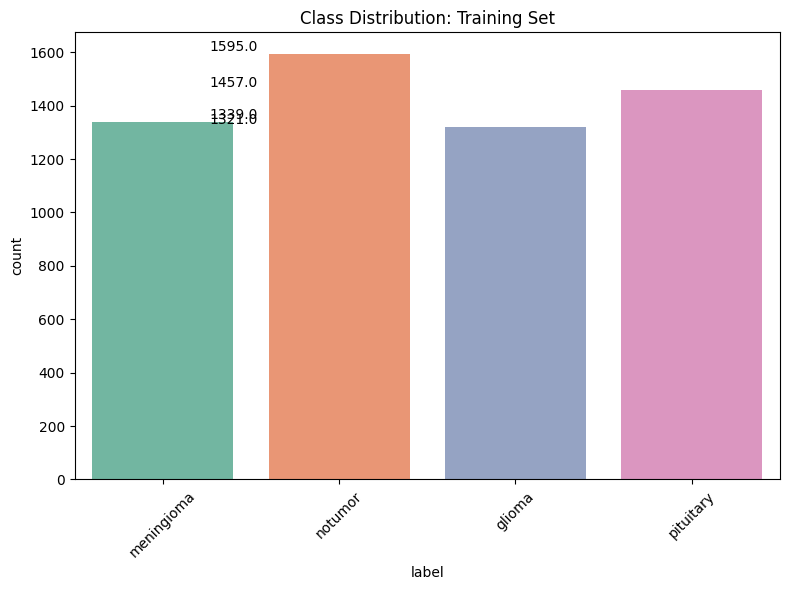

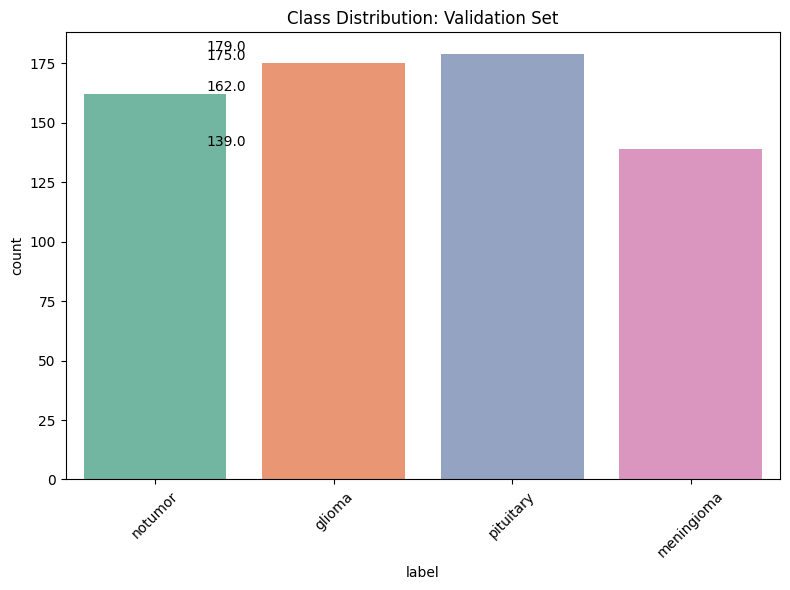

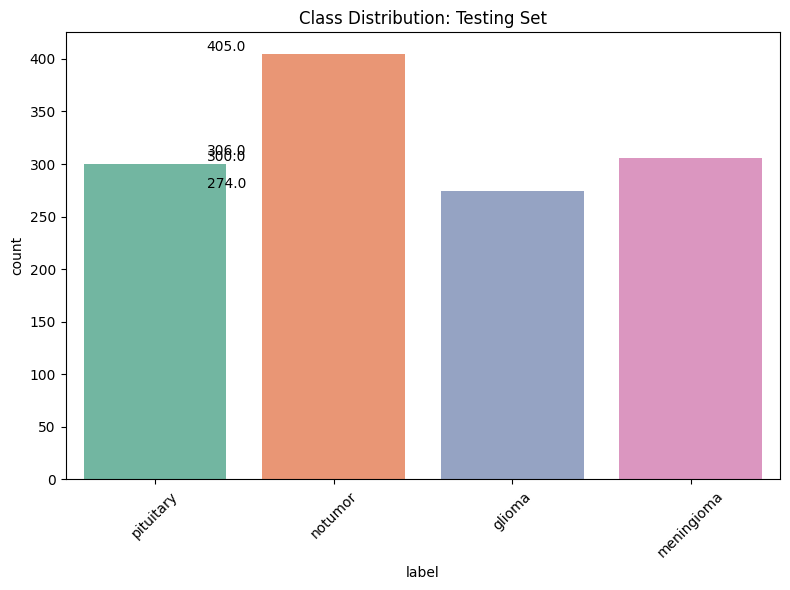

In [25]:
def plot_class_distribution(df, title):
    plt.figure(figsize = (8, 6))
    sns.countplot(x = 'label', data = df, palette = 'Set2')
    plt.title(f'Class Distribution: {title}')
    plt.xticks(rotation = 45)
    for p in plt.gca().patches:
        plt.gca().annotate(f'{p.get_height()}', 
                           (p.get_width() / 2, p.get_height()), 
                           ha = 'center', 
                           va = 'bottom', 
                           fontsize = 10,
                           color = 'black')
    plt.tight_layout()
    plt.show()
    
plot_class_distribution(train_df, 'Training Set')
plot_class_distribution(val_df, 'Validation Set')
plot_class_distribution(test_df, 'Testing Set')

            Width      Height
count  100.000000  100.000000
mean   436.240000  445.070000
std    134.695775  130.664367
min    150.000000  168.000000
25%    345.500000  383.250000
50%    512.000000  512.000000
75%    512.000000  512.000000
max    850.000000  872.000000


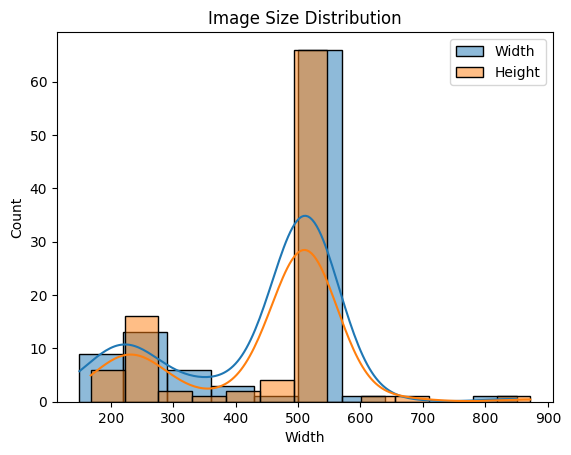

In [26]:
def check_image_sizes(df, sample_size=100):
    dimensions = []
    for path in df['file'].sample(n=min(sample_size, len(df)), random_state=SEED):
        img = Image.open(path)
        dimensions.append(img.size)
    dims_df = pd.DataFrame(dimensions, columns=['Width', 'Height'])
    print(dims_df.describe())
    sns.histplot(dims_df['Width'], kde=True, label='Width')
    sns.histplot(dims_df['Height'], kde=True, label='Height')
    plt.legend()
    plt.title('Image Size Distribution')
    plt.show()

check_image_sizes(train_df)

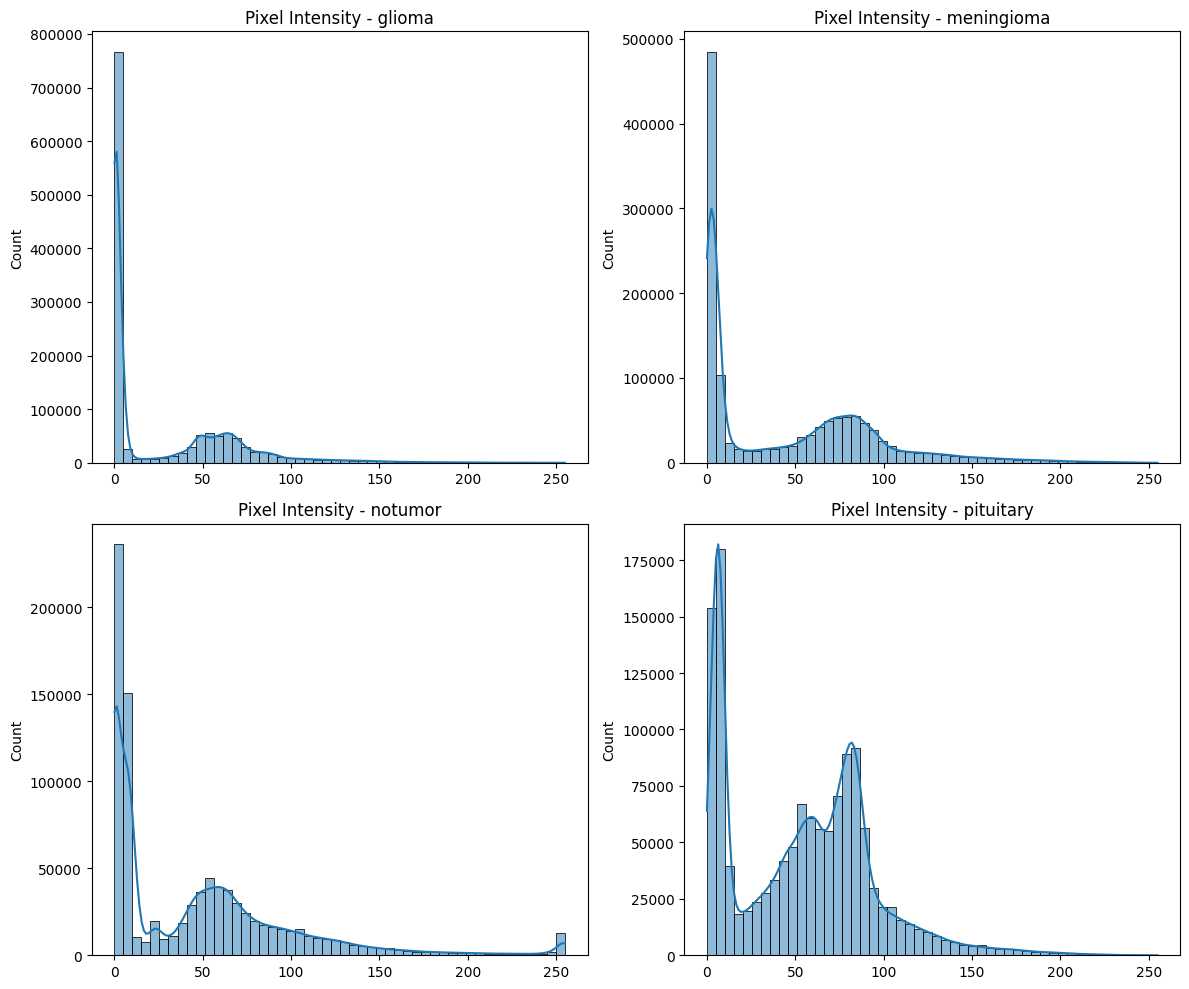

In [27]:
def plot_pixel_intensity(df, sample_size=5):
    fig, axs = plt.subplots(2, 2, figsize=(12,10))
    axs = axs.flatten()

    for idx, category in enumerate(CATEGORIES):
        img_paths = df[df['label'] == category]['file'].values[:sample_size]
        pixels = []
        for path in img_paths:
            img = Image.open(path).convert('L')
            pixels.extend(np.array(img).flatten())
        sns.histplot(pixels, bins=50, kde=True, ax=axs[idx])
        axs[idx].set_title(f'Pixel Intensity - {category}')

    plt.tight_layout()
    plt.show()

plot_pixel_intensity(train_df)


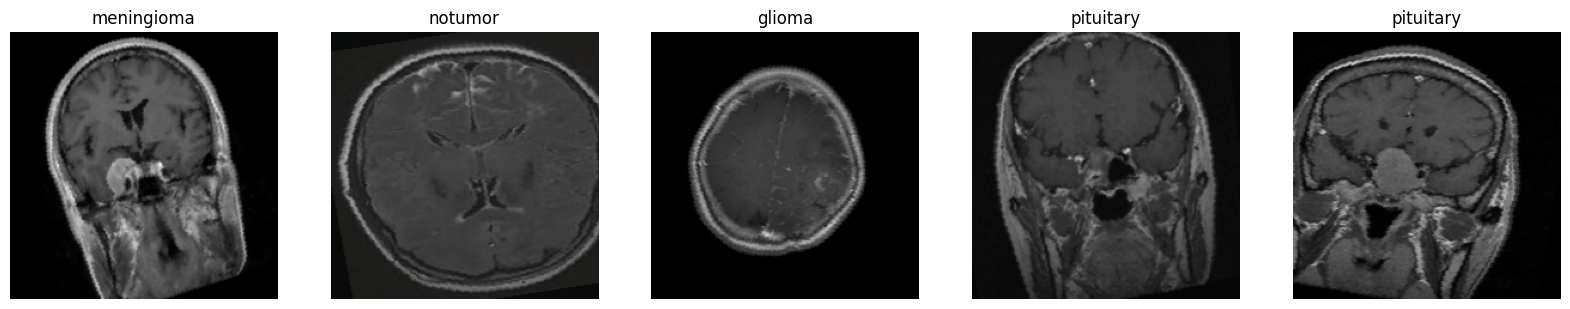

In [28]:
def visualize_augmentations(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).cpu().numpy()
        img = (img * np.array(imagenet_std) + np.array(imagenet_mean))
        img = np.clip(img, 0, 1)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(CATEGORIES[label])
    plt.show()

visualize_augmentations(train_dataset)


Model Architecture

In [29]:
def build_model(num_classes):
    model = models.mobilenet_v2(pretrained = True)
    
    for param in model.parameters():
        param.requires_grad = False
    
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
    nn.Linear(in_features, 2048),
    nn.ReLU(),
    nn.BatchNorm1d(2048),
    nn.Dropout(0.4),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Dropout(0.4),
    nn.Linear(1024, num_classes)
    )
    return model.to(device)

model = build_model(NUM_CLASSES)
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [30]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, scheduler=None):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    scaler = torch.amp.GradScaler()
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        epoch_start = time.time()

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    with torch.amp.autocast(device_type='cuda'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += inputs.size(0)

                if i % 10 == 0 and phase == 'train':
                    print(f"[{phase}] Batch {i+1}/{len(dataloaders[phase])}")
                    allocated = torch.cuda.memory_allocated() / (1024**2)
                    reserved = torch.cuda.memory_reserved() / (1024**2)
                    print(f"[Batch {i}] Allocated: {allocated:.2f}MB | Reserved: {reserved:.2f}MB")

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects.double() / total_samples

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= 5:
                        print(f"\nEarly stopping triggered at epoch {epoch+1}")
                        model.load_state_dict(best_model_wts)
                        return model, history

        if scheduler:
            scheduler.step()

        epoch_time = time.time() - epoch_start
        print(f'Epoch {epoch+1} completed in {epoch_time:.2f} seconds.')

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Accuracy: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model, history

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
dataloaders = {'train': train_loader, 
               'val': val_loader}

In [32]:
NUM_TOTAL_EPOCHS = NUM_EPOCHS_INITIAL + NUM_EPOCHS_FINE_TUNE
print("Starting training...")
print("Model on:", next(model.parameters()).device)
print("Train loader size:", len(train_loader))


model, history = train_model(model, 
                             dataloaders, 
                             criterion, 
                             optimizer, 
                             num_epochs=NUM_TOTAL_EPOCHS, 
                             scheduler=scheduler)

Starting training...
Model on: cuda:0
Train loader size: 179

Epoch 1/20
------------------------------
[train] Batch 1/179
[Batch 0] Allocated: 142.32MB | Reserved: 324.00MB
[train] Batch 11/179
[Batch 10] Allocated: 142.32MB | Reserved: 398.00MB
[train] Batch 21/179
[Batch 20] Allocated: 142.32MB | Reserved: 398.00MB
[train] Batch 31/179
[Batch 30] Allocated: 142.32MB | Reserved: 398.00MB
[train] Batch 41/179
[Batch 40] Allocated: 142.32MB | Reserved: 398.00MB
[train] Batch 51/179
[Batch 50] Allocated: 142.32MB | Reserved: 398.00MB
[train] Batch 61/179
[Batch 60] Allocated: 142.32MB | Reserved: 398.00MB
[train] Batch 71/179
[Batch 70] Allocated: 142.32MB | Reserved: 398.00MB
[train] Batch 81/179
[Batch 80] Allocated: 142.32MB | Reserved: 398.00MB
[train] Batch 91/179
[Batch 90] Allocated: 142.32MB | Reserved: 398.00MB
[train] Batch 101/179
[Batch 100] Allocated: 142.32MB | Reserved: 398.00MB
[train] Batch 111/179
[Batch 110] Allocated: 142.32MB | Reserved: 398.00MB
[train] Batch 121/

Evaluation

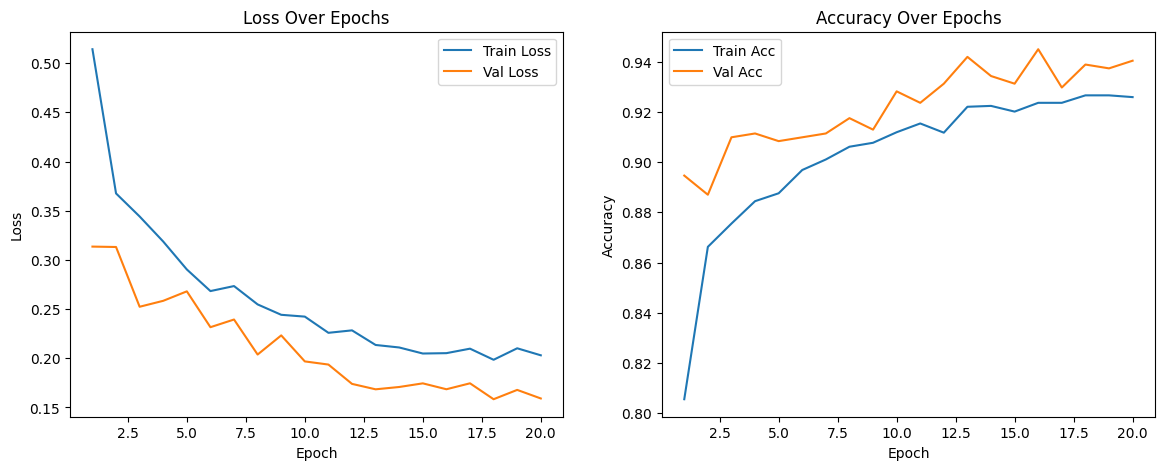

In [33]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training_history(history)



Classification Report:
              precision    recall  f1-score   support

      glioma       0.92      0.87      0.90       274
  meningioma       0.86      0.83      0.84       306
     notumor       0.95      1.00      0.97       405
   pituitary       0.94      0.96      0.95       300

    accuracy                           0.92      1285
   macro avg       0.92      0.91      0.92      1285
weighted avg       0.92      0.92      0.92      1285



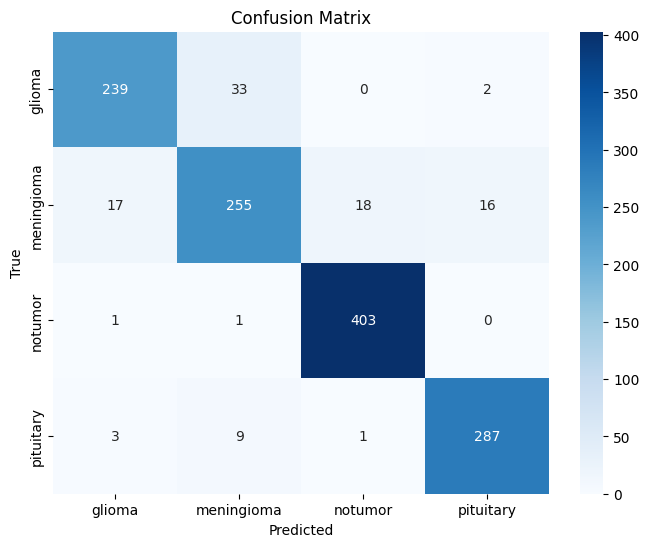

In [34]:
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return np.array(y_true), np.array(y_pred)

y_true, y_pred = evaluate_model(model, test_loader)

print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=CATEGORIES))

conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


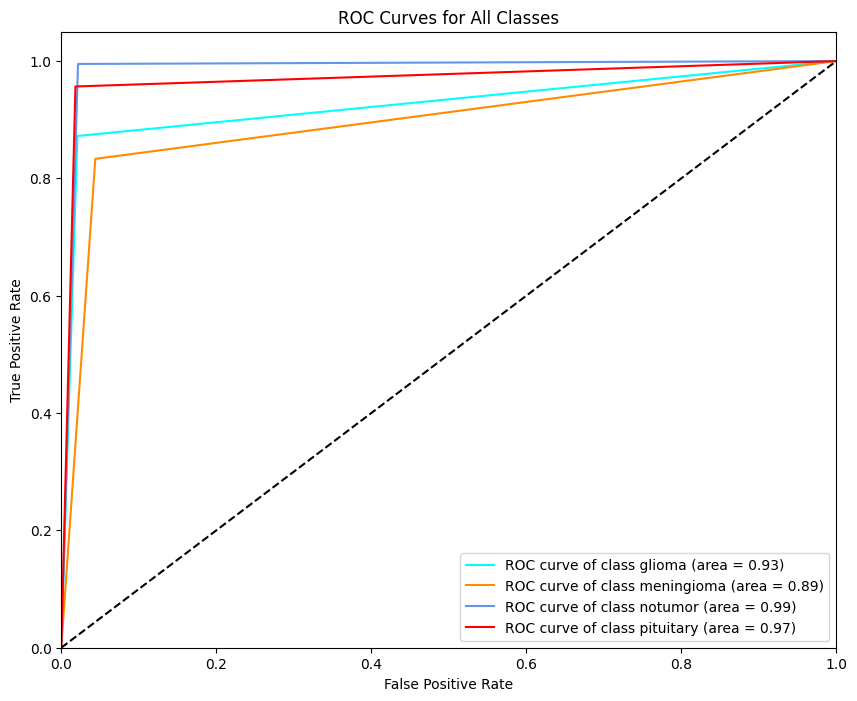

In [35]:
def plot_roc(y_true, y_pred, n_classes):
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
    y_pred_bin = label_binarize(y_pred, classes=list(range(n_classes)))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = ['aqua', 'darkorange', 'cornflowerblue', 'red']
    plt.figure(figsize=(10,8))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label=f'ROC curve of class {CATEGORIES[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Classes')
    plt.legend(loc='lower right')
    plt.show()

plot_roc(y_true, y_pred, NUM_CLASSES)


In [36]:
MODEL_SAVE_PATH = 'best_brain_tumor_model.pth'

torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved at {MODEL_SAVE_PATH}")

Model saved at best_brain_tumor_model.pth


In [46]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

        for param in self.target_layer.parameters():
            param.requires_grad = True

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, class_idx=None):
        self.model.eval()
        input_tensor = input_tensor.unsqueeze(0).to(device)

        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax().item()

        self.model.zero_grad()
        target = output[0, class_idx]
        target.backward(retain_graph=True)

        if self.gradients is None:
            raise ValueError("Gradients not captured. Check target layer or hook setup.")

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)

        cam = f.resize(cam, size=(IMG_SIZE, IMG_SIZE))
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

In [47]:
def show_gradcam(model, dataset, index, target_layer):
    grad_cam = GradCAM(model, target_layer)
    image_tensor, label = dataset[index]

    cam = grad_cam.generate_cam(image_tensor)

    image_np = image_tensor.permute(1, 2, 0).numpy()
    image_np = (image_np * np.array(imagenet_std) + np.array(imagenet_mean))
    image_np = np.clip(image_np, 0, 1)

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap + image_np
    overlay = overlay / np.max(overlay)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(cam, cmap='jet')
    plt.title("Grad-CAM Map")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis("off")

    pred_label = model(image_tensor.unsqueeze(0).to(device)).argmax().item()
    plt.suptitle(f"True: {CATEGORIES[label]} | Pred: {CATEGORIES[pred_label]}")
    plt.tight_layout()
    plt.show()

In [49]:
def show_gradcam_per_class(model, dataset, target_layer, categories):
    shown_classes = set()
    
    for idx in range(len(dataset)):
        image_tensor, label = dataset[idx]
        if label not in shown_classes:
            print(f"Class: {categories[label]} (index {idx})")
            show_gradcam(model, dataset, index=idx, target_layer=target_layer)
            shown_classes.add(label)
        if len(shown_classes) == len(categories):
            break


Class: pituitary (index 0)


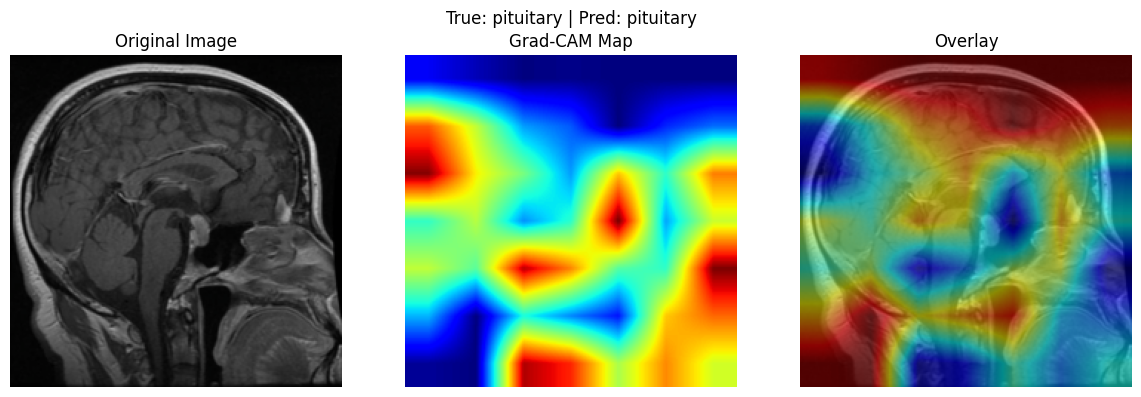

Class: notumor (index 1)


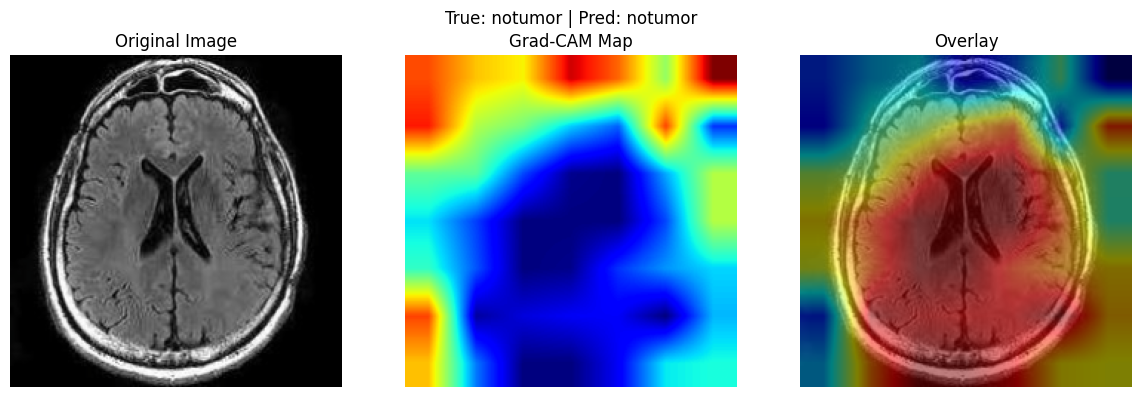

Class: glioma (index 6)


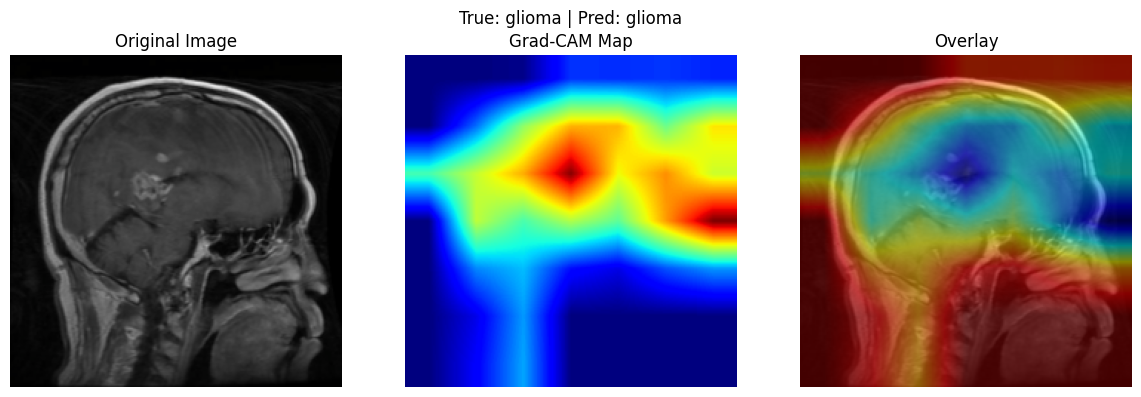

Class: meningioma (index 8)


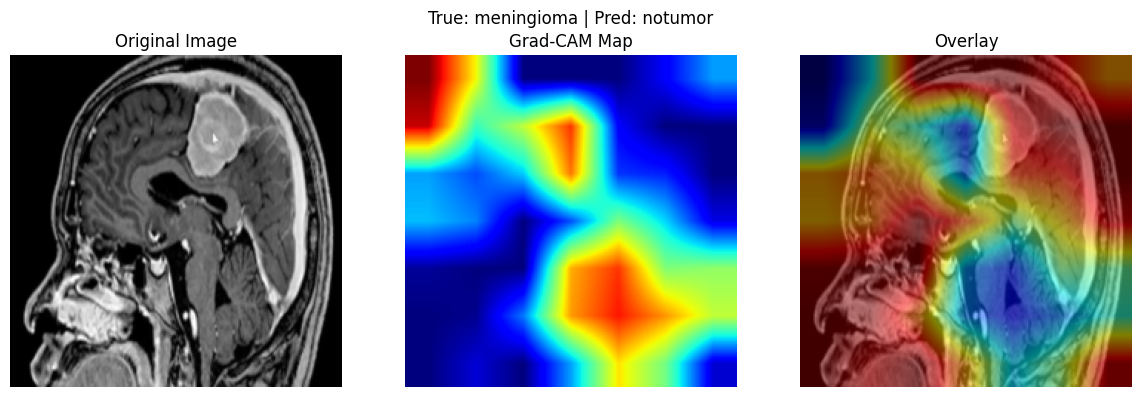

In [51]:
target_conv_layer = model.features[16]

show_gradcam_per_class(
    model=model,
    dataset=test_dataset,
    target_layer=target_conv_layer,
    categories=CATEGORIES
)
